<img src="https://fsdl.me/logo-720-dark-horizontal">

# Lab 07: Deployment

## What You Will Learn

- How to convert PyTorch models into portable TorchScript binaries
- How to use `gradio` to make a simple demo UI for your ML-powered applications
- How to split out a model service from the frontend and spin up a publicly accessible application

# Setup

In [ ]:
lab_idx = 7


if "bootstrap" not in locals() or bootstrap.run:
    # path management for Python
    pythonpath, = !echo $PYTHONPATH
    if "." not in pythonpath.split(":"):
        pythonpath = ".:" + pythonpath
        %env PYTHONPATH={pythonpath}
        !echo $PYTHONPATH

    # get both Colab and local notebooks into the same state
    !wget --quiet https://fsdl.me/gist-bootstrap -O bootstrap.py
    import bootstrap

    # change into the lab directory
    bootstrap.change_to_lab_dir(lab_idx=lab_idx)

    bootstrap.run = False  # change to True re-run setup
    
!pwd
%ls

Change to the current directory:

In [1]:
import os
os.chdir("D:/RL_Finance/MLops/fslab/lab07")

print(os.getcwd())

D:\RL_Finance\MLops\fslab\lab07


In [2]:
from IPython.display import display, HTML, IFrame

full_width = True
frame_height = 720  # adjust for your screen

if full_width:  # if we want the notebook to take up the whole width
    # add styling to the notebook's HTML directly
    display(HTML("<style>.container { width:100% !important; }</style>"))
    display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

### Follow along with a video walkthrough on YouTube:

In [3]:
from IPython.display import IFrame


IFrame(src="https://fsdl.me/2022-lab-07-video-embed", width="100%", height=720)

# Making the model portable

While training the model,
we've saved checkpoints and stored them locally
and on W&B.

From these checkpoints, we can reload model weights
and even restart training if we are in or can recreate
the model development environment.

We could directly deploy these checkpoints into production,
but they're suboptimal for two reasons.

First, as the name suggests,
these "checkpoints" are designed for serializing
state at a point of time in training.

That means they can include lots of information
not relevant during inference,
e.g. optimizer states like running average gradients.

Additionally, the model development environment
is much more heavyweight than what we need during inference.

For example, we've got Lightning for training models
and W&B for tracking training runs.

These in turn incur dependencies on lots of heavy data science libraries.

We don't need this anymore -- we just want to run the model.

These are effectively "compiler tools", which our runtime model doesn't need.

So we need a new model binary artifact for runtime
that's leaner and more independent.

For this purpose, we use TorchScript.

## Compiling models to TorchScript

Torch has two main facilities for creating
more portable model binaries:
_scripting_ and _tracing_.

Scripting produces a binary that combines
constant `Tensor` values
(like weights and positional embeddings)
with a program that describes how to use them.

The result is a program that creates a dynamic graph,
as does a normal PyTorch program,
but this program is written in a
sub-dialect of Python called
_TorchScript_.

The [TorchScript sub-dialect of Python](https://pytorch.org/docs/stable/jit_language_reference.html#language-reference)
is more performant
and can even be run without a Python interpreter.

For example, TorchScript programs can be executed in pure C++
[using LibTorch](https://pytorch.org/tutorials/advanced/cpp_export.html).

You can read more in the documentation for the primary method
for scripting models, `torch.jit.script`:

In [3]:
import torch


torch.jit.script??

Signature:
torch.jit.script(
    obj,
    optimize=None,
    _frames_up=0,
    _rcb=None,
    example_inputs: Union[List[Tuple], Dict[Callable, List[Tuple]], NoneType] = None,
)
Source:   
def script(
    obj,
    optimize=None,
    _frames_up=0,
    _rcb=None,
    example_inputs: Union[List[Tuple], Dict[Callable, List[Tuple]], None] = None,
):
    r"""Script the function.

    Scripting a function or ``nn.Module`` will inspect the source code, compile
    it as TorchScript code using the TorchScript compiler, and return a :class:`ScriptModule` or
    :class:`ScriptFunction`. TorchScript itself is a subset of the Python language, so not all
    features in Python work, but we provide enough functionality to compute on
    tensors and do control-dependent operations. For a complete guide, see the
    :ref:`language-reference`.

    Scripting a dictionary or list copies the data inside it into a TorchScript instance than can be
    subsequently passed by reference between Python and Torc

The primary alternative to scripting is _tracing_,
which runs the PyTorch module on a specific
set of inputs and records, or "traces",
the compute graph.

You can read more about it in the documentation for the primary method
for tracing models, `torch.jit.trace`,
or just read the quick summary and comparison below.

In [6]:
torch.jit.trace??

Signature:
torch.jit.trace(
    func,
    example_inputs=None,
    optimize=None,
    check_trace=True,
    check_inputs=None,
    check_tolerance=1e-05,
    strict=True,
    _force_outplace=False,
    _module_class=None,
    _compilation_unit=<torch.jit.CompilationUnit object at 0x000001DD23A51FF0>,
    example_kwarg_inputs=None,
    _store_inputs=True,
)
Source:   
def trace(
    func,
    example_inputs=None,
    optimize=None,
    check_trace=True,
    check_inputs=None,
    check_tolerance=1e-5,
    strict=True,
    _force_outplace=False,
    _module_class=None,
    _compilation_unit=_python_cu,
    example_kwarg_inputs=None,
    _store_inputs=True,
):
    r"""
    Trace a function and return an executable  or :class:`ScriptFunction` that will be optimized using just-in-time compilation.

    Tracing is ideal for code that operates only on
    ``Tensor``\\s and lists, dictionaries, and
    tuples of ``Tensor``\\s.

    Using `torch.jit.trace` and `torch.jit.trace_module`, you can 

### Tracing versus Scripting for TorchScript

The traced program is generally faster than the scripted version,
for models that are compatible with both tracing and scripting.

Tracing produces a static compute graph,
which means all control flow
(`if`s or `for` loops)
are effectively inlined.

As written, our text recognizer has a loop with conditional breaking -- fairly typical for Transformers in autoregressive mode --
so it isn't compatible with tracing.

Furthermore, the static compute graph includes concrete choices of operations,
e.g. specific CUDA kernels if tracing is run on the GPU.

If you try to run the traced model on a system that doesn't support those kernels,
it will crash.
That means tracing must occur in the target deployment environment.

Scripted models are much more portable, at the cost of both slower runtimes
for a fixed hardware target and of some restrictions on how dynamic the Python code can be.

We don't find the restrictions scripting places on Python code to be too onerous
and in our experience, the performance gains are not worth the extra effort
until the team size is larger,
model serving hardware and strategy is more mature,
and model release cycles are slower.

For an alternative perspective that's more in favor of tracing
and walks through how to mix-and-match scripting
and tracing for maximum flexibility and performance, see
[this blogpost](https://ppwwyyxx.com/blog/2022/TorchScript-Tracing-vs-Scripting/)
from
[Detectron2](https://ai.facebook.com/blog/-detectron2-a-pytorch-based-modular-object-detection-library-/)
dev Yuxin Wu.

Choosing just one of scripting or tracing
means we can use a high-level method
from PyTorch Lightning,
`to_torchscript`,
to produce our scripted model binary
and we don't need to touch our model code.

In [7]:
import pytorch_lightning as pl


pl.LightningModule.to_torchscript??

Signature:
pl.LightningModule.to_torchscript(
    self,
    file_path: Union[str, pathlib.Path, NoneType] = None,
    method: Optional[str] = 'script',
    example_inputs: Optional[Any] = None,
    **kwargs: Any,
) -> Union[torch.ScriptModule, Dict[str, torch.ScriptModule]]
Source:   
    @torch.no_grad()
    def to_torchscript(
        self,
        file_path: Optional[Union[str, Path]] = None,
        method: Optional[str] = "script",
        example_inputs: Optional[Any] = None,
        **kwargs: Any,
    ) -> Union[ScriptModule, Dict[str, ScriptModule]]:
        """By default compiles the whole model to a :class:`~torch.jit.ScriptModule`. If you want to use tracing,
        please provided the argument ``method='trace'`` and make sure that either the `example_inputs` argument is
        provided, or the model has :attr:`example_input_array` set. If you would like to customize the modules that are
        scripted you should override this method. In case you want to return multiple 

## Alternatives to TorchScript

Though it has some sharp edges,
TorchScript is a relatively easy to use tool
for compiling neural networks written in PyTorch.

If you're willing to tolerate more sharp edges,
e.g. limited support for certain ops
and a higher risk of subtle differences in behavior, the
[Open Neural Network eXchange](https://onnx.ai/)
format, ONNX, is a compilation target for
[a wide variety of DNN libraries](https://onnx.ai/supported-tools.html),
from `sklearn` and MATLAB
to PyTorch and Hugging Face.

A high-level utility for conversion to ONNX is also included
in PyTorch Lightning, `pl.LightningModule.to_onnx`.

Because it is framework agnostic,
there's more and more varied tooling around ONNX,
and it has smoother paths to
compilation targets that can run DNNs
at the highest possible speeds,
like
[NVIDIA's TensorRT](https://developer.nvidia.com/tensorrt)
or
[Apache TVM](https://tvm.apache.org/2017/08/17/tvm-release-announcement).

TensorRT is the model format used in the
[Triton Inference Server](https://github.com/triton-inference-server/server),
a sort of "kubernetes for GPU-accelerated DNNs"
that is, as of 2022,
the state of the art in running deep networks
at maximum throughput on server-grade GPUs.


## A simple script for compiling and staging models

To recap, our model staging workflow,
which does the hand-off between training and production, looks like this:

1. Get model weights and hyperparameters
from a tracked training run in W&B's cloud storage.
2. Reload the model as a `LightningModule` using those weights and hyperparameters.
3. Call `to_torchscript` on it.
4. Save that result to W&B's cloud storage.

We provide a simple script to implement this process:

In [8]:
%run training/stage_model.py --help

usage: stage_model.py [-h] [--fetch] [--entity ENTITY]
                      [--from_project FROM_PROJECT] [--to_project TO_PROJECT]
                      [--run RUN] [--ckpt_alias CKPT_ALIAS]
                      [--staged_model_name STAGED_MODEL_NAME]

Stages a model for use in production. If based on a checkpoint, the model is
converted to torchscript, saved locally, and uploaded to W&B. If based on a
model that is already converted and uploaded, the model file is downloaded
locally. For details on how the W&B artifacts backing the checkpoints and
models are handled, see the documenation for stage_model.find_artifact.

options:
  -h, --help            show this help message and exit
  --fetch               If provided, check ENTITY/FROM_PROJECT for an artifact
                        with the provided STAGED_MODEL_NAME and download its
                        latest version to D:\RL_Finance\MLops\fslab\lab07\text
                        _recognizer\artifacts/STAGED_MODEL_NAME.
  --

Here in this notebook,
rather than training or scripting a model ourselves,
we'll just `--fetch`
an already trained and scripted model binary:

In [ ]:
from pathlib import Path
PROJECT_ROOT = Path(__file__).resolve().parents[1]
PROJECT_ROOT

NameError: name '__file__' is not defined

In [4]:
from training import stage_model

In [15]:
from pathlib import Path
PROJECT_ROOT = Path(stage_model.__file__).resolve().parents[1]
PROD_STAGING_ROOT = PROJECT_ROOT / "text_recognizer" / "artifacts"
PROD_STAGING_ROOT

WindowsPath('D:/RL_Finance/MLops/fslab/lab07/text_recognizer/artifacts')

In [16]:
import wandb


api = wandb.Api()
DEFAULT_ENTITY = api.default_entity
DEFAULT_ENTITY

'xiangyexu-university-of-waterloo'

In [19]:
f"cfrye59/fsdl-text-recognizer-2021-training/paragraph-text-recognizer:latest"


'cfrye59/fsdl-text-recognizer-2021-training/paragraph-text-recognizer:latest'

In [10]:
%run training/stage_model.py --fetch --entity=cfrye59 --from_project=fsdl-text-recognizer-2021-training

wandb: Downloading large artifact paragraph-text-recognizer:latest, 416.00MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:41.0


Using artifact cfrye59/fsdl-text-recognizer-2021-training/paragraph-text-recognizer:latest
View at URL: https://wandb.ai/cfrye59/fsdl-text-recognizer-2021-training/artifacts/prod-ready/paragraph-text-recognizer/latest
Logged by glad-glitter-429 -- fsdl-text-recognizer-2021-training/cfrye59/2aaexmgd
View at URL: https://wandb.ai/cfrye59/fsdl-text-recognizer-2021-training/runs/2aaexmgd


Note that we can use the metadata of the staged model
to find the training run that generated the model weights.
It requires two graph hops:
find the run that created the staged TorchScript model
then in that run,
find the model checkpoint artifact
and look for the run that created it.

In [ ]:
from IPython import display


staged_model_url = "https://wandb.ai/cfrye59/fsdl-text-recognizer-2021-training/artifacts/prod-ready/paragraph-text-recognizer/3e07efa34aec61999c5a/overview"

IFrame(staged_model_url, width="100%", height=720)

When we're deploying our first model,
this doesn't feel that important --
it's easy enough to find the training runs
we've executed and connect them to the model in production.

But as we train and release more models,
this information will become harder to find
and automation and API access will become more important.

This will be especially true if we adopt more sophisticated rollout strategies,
like A/B testing or canarying,
as the application matures.

Our system here is not robust enough to be Enterprise Grade™️ --
marking models as "in production" is manual
and there are no access control planes built in --
but at least the information is preserved.

## Running our more portable model via a CLI

Now that our TorchScript model binary file is present,
we can spin up our text recognizer
with much less code.

We just need a compatible version of PyTorch
and methods to convert
our generic data types
(images, strings)
to and from PyTorch `Tensor`s.

We can put all this together in
a single light-weight object,
the `ParagraphTextRecognizer` class:

In [2]:
from text_recognizer.paragraph_text_recognizer import ParagraphTextRecognizer


ParagraphTextRecognizer??

ptr = ParagraphTextRecognizer()

Init signature: ParagraphTextRecognizer(model_path=None)
Source:        
class ParagraphTextRecognizer:
    """Recognizes a paragraph of text in an image."""

    def __init__(self, model_path=None):
        if model_path is None:
            model_path = STAGED_MODEL_DIRNAME / MODEL_FILE
        self.model = torch.jit.load(model_path)
        self.mapping = self.model.mapping
        self.ignore_tokens = self.model.ignore_tokens
        self.stem = ParagraphStem()

    @torch.no_grad()
    def predict(self, image: Union[str, Path, Image.Image]) -> str:
        """Predict/infer text in input image (which can be a file path or url)."""
        image_pil = image
        if not isinstance(image, Image.Image):
            image_pil = util.read_image_pil(image, grayscale=True)

        image_tensor = self.stem(image_pil).unsqueeze(axis=0)
        y_pred = self.model(image_tensor)[0]
        pred_str = convert_y_label_to_string(y=y_pred, mapping=self.mapping, ignore_tokens=self.ignore_tokens

And from there,
we can start running on images
and inferring the text that they contain:

And, since this is election year in West
Germany, Dr. Adenauer is in a tough
spot. Joyce Egginton cables: President
Kennedy at his Washington Press con-
ference admitted he did not know
whether America was lagging behind
Russia in missile power. He said he
was waiting for his senior military
aides to come up with the answer on
February 20.


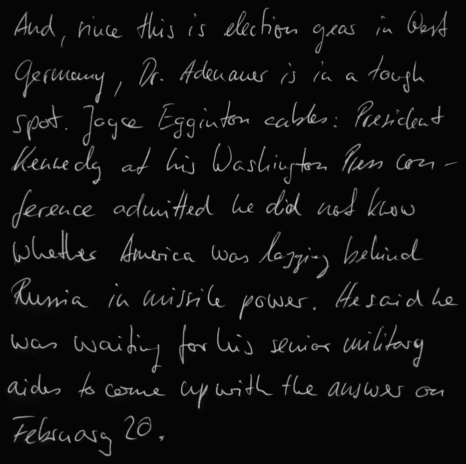

In [6]:
from IPython.display import Image

example_input = "text_recognizer/tests/support/paragraphs/a01-077.png"

print(ptr.predict(example_input))
Image(example_input)

As usual,
we write our Python code
so that it can be imported as a module
and run in a Jupyter notebook,
for documentation and experimentation,
and we make it executable as a script
for easier automation:

In [ ]:
## %run text_recognizer/paragraph_text_recognizer.py --help


## Here we use directly the script to produce result
%run text_recognizer/paragraph_text_recognizer.py {example_input}

And, since this is election year in West
Germany, Dr. Adenauer is in a tough
spot. Joyce Egginton cables: President
Kennedy at his Washington Press con-
ference admitted he did not know
whether America was lagging behind
Russia in missile power. He said he
was waiting for his senior military
aides to come up with the answer on
February 20.


Notice that the `filename` here can be a local file, a URL, or even a cloud storage URI.

Rather than writing the logic for handling these different cases,
we use the
[`smart_open` library](https://pypi.org/project/smart-open/).

## Testing our model development pipeline

Creating models is _the_ critical function of our code base,
so it's important that we test it,
at the very least with "smoke tests" that let us know
if the code is completely broken.

Right now we have tests for data loading and model training,
but no tests for end-to-end model development,
which combines data loading, model training, and model compilation.

So we add a simple model development test
that trains a model for a very small number of steps
and then runs our staging script.

This model development test script returns an error code (`exit 1`) if the process of
building a model fails (`"$FAILURE" = true`).

We use
[the `||` operator](https://www.unix.com/shell-programming-and-scripting/42417-what-does-mean-double-pipe.html)
to set the `FAILURE` variable to `true` if any of the key commands in model development fail.

In [23]:
!cat training/tests/test_model_development.sh

'cat' is not recognized as an internal or external command,
operable program or batch file.


In [24]:
with open("training/tests/test_model_development.sh", "r") as f:
    print(f.read())

#!/bin/bash
set -uo pipefail
set +e

FAILURE=false

CI="${CI:-false}"
if [ "$CI" = false ]; then
  export WANDB_PROJECT="fsdl-testing-2022"
else
  export WANDB_PROJECT="fsdl-testing-2022-ci"
fi

echo "training smaller version of real model class on real data"
python training/run_experiment.py --data_class=IAMParagraphs --model_class=ResnetTransformer --loss=transformer \
  --tf_dim 4 --tf_fc_dim 2 --tf_layers 2 --tf_nhead 2 --batch_size 2 --lr 0.0001 \
  --limit_train_batches 1 --limit_val_batches 1 --limit_test_batches 1 --num_sanity_val_steps 0 \
  --num_workers 1 --wandb || FAILURE=true

TRAIN_RUN=$(find ./training/logs/wandb/latest-run/* | grep -Eo "run-([[:alnum:]])+\.wandb" | sed -e "s/^run-//" -e "s/\.wandb//")

echo "staging trained model from run $TRAIN_RUN"
python training/stage_model.py --entity DEFAULT --run "$TRAIN_RUN" --staged_model_name test-dummy --ckpt_alias latest --to_project "$WANDB_PROJECT" --from_project "$WANDB_PROJECT" || FAILURE=true

echo "fetching staged mod

As a next step to improve the coverage of this test,
we might compare the model's outputs
on the same inputs before and after compilation.

### Cleaning up artifacts

The final few lines of the testing script mention
"`selecting for deletion`" some artifacts.

As we incorporate more of our code into testing
and develop more models,
the amount of information we are storing on W&B increases.

We're already uploading model checkpoints, several gigabytes per model training run,
and now we're also looking at uploading several hundred megabytes
of model data per execution of our test.

Artifact storage is free up to 100GB,
but storing more requires a paid account.

That means it literally pays to clean up after ourselves.

We use a very simple script to select certain artifacts for deletion.
 
> ⚠️ **Don't use this untested demonstration script in important environments!** ⚠️
We include options for `-v`erbose output and a `--dryrun` mode,
which are both critical for destructive actions that have access
to model weights that might cost $1000s to produce.

See the `--help` below for more on cleaning up artifacts.

In [2]:
%run training/cleanup_artifacts.py --help

usage: cleanup_artifacts.py [-h] [--entity ENTITY] [--project PROJECT]
                            [--run_ids [RUN_IDS ...]]
                            [--run_name_res [RUN_NAME_REGEX ...]]
                            [--all | --no-alias | --aliases [ALIASES ...]]
                            [-v] [--dryrun]

Removes artifacts from projects and runs. Artifacts are binary files that we
want to track and version but don't want to include in git, generally because
they are too large, because they don't have meaningful diffs, or because they
change more quickly than code. During development, we often generate artifacts
that we don't really need, e.g. model weights for an overfitting test run.
Space on artifact storage is generally very large, but it is limited, so we
should occasionally delete unneeded artifacts to reclaim some of that space.
For usage help, run python training/cleanup_artifacts.py --help

options:
  -h, --help            show this help message and exit
  --entity ENTITY  

## Tuning inference performance on CPU and GPU

Apart from compilation to TorchScript,
the biggest difference for running the model in production
is that now all of our operations occur on the CPU.

This is a surprising feature of DNN deployment
that's worth thinking about in detail.

Why isn't it a given that deep network inference
runs on GPUs, when that's so critical for deep network training?

First,
not many web applications use GPUs,
so there aren't nearly as many good tools and techniques
for deplyoing GPU-backed services.

But there's another, deeper reason:
GPUs are not as easy to run efficiently
during inference as they are in training.

In training,
we use static or synthetic datasets
and our training code is in charge
of the query patterns.

In particular,
we can request exactly as many inputs
as we want to produce a batch
that makes optimal use
of our expensive GPUs.

In production, requests arrive independently,
according to the whims of our users.

This makes batching challenging,
and by far the simplest service architecture
just runs on each request as it arrives.

But that tanks GPU utilization.

GPUs are highly parallel computers,
and batch is the easiest dimension to parallelize on --
for example, we load the model weights into memory once,
use them, and then release the memory.

The cell below
compares two traces
for a GPU-accelerated
Text Recognizer model running
on a single input and on a batch.

For a simple summary,
you can compare the two profiles in TensorBoard
([batch size 1 here](https://wandb.ai/cfrye59/fsdl-text-recognizer-2022-labs-lab05_training/runs/1vj48h6j/tensorboard?workspace=user-cfrye59),
[batch size 16 here](https://wandb.ai/cfrye59/fsdl-text-recognizer-2022-training/runs/67j1qxws/tensorboard?workspace=user-cfrye59)).

GPU utilization,
our baseline metric for model performance,
is under 50% with batch size 1,
as compared to >90% with batch size 16,
which fills up GPU RAM.

You can also look through the traces for more details:

In [ ]:
trace_comparison_url = "https://wandb.ai/cfrye59/fsdl-text-recognizer-2022-labs-lab05_training/reports/Trace-Comparison-Batch-Size-16-vs-1--VmlldzoyNTg2MTU4"

print(trace_comparison_url)
IFrame(src=trace_comparison_url, width="100%", height=frame_height)

But performance during inference is not as simple 
as just "maximize GPU utilization".

In particular, throughput for the GPU with batch size 16
is over 2x better,
one example per 8 ms vs
one example per 40 ms,
but latency is much worse.

It takes 140ms to complete the batch of size 16.
In the intervening time no examples are completed,
and all 16 users are waiting on a response.

For comparison,
running one example at a time
would get the first user's result
in just 40 ms,
but the total processing time for all 16 examples would be
640 ms.

For user experience, latency is critical,
but for making the most efficient use of hardware,
throughput is generally more important.

During training, we care much less about latency
and much more about computing gradients as fast as possible,
so we aim for larger batch sizes.

Because of the need for efficient use of hardware,
running on single inputs isn't always feasible.

The usual solution is to run a queue,
which collects up enough requests for a batch.

One of the easiest ways to do this as of writing in September 2022 is to use
[`cog` by Replicate](https://github.com/replicate/cog),
which both solves difficult issues with containerizing
models with GPU acceleration 
and includes, as a beta feature, a built-in Redis queue
for batching requests and responses.

But note that we can't just run a queue that waits for,
say, 16 user requests
to build up, then runs them all.
If 15 requests come in at once,
but then no requests come for an hour,
all 15 users will be waiting for an hour
for their responses --
much worse than just waiting a few hundred extra milliseconds!

We need to make sure the queue flushes after a certain amount of time,
regardless of how many requests it has received,
complicating our implementation.

Running single inputs on GPUs
and running a naive queue
are two different ways it's easy to accidentally tank latency
while pursuing efficiency,
at least for some fraction of cases.

So we stick with CPU inference.

# Building a simple model UI

With compilation,
we've moved from a model that can only run
in a very special environment
and with lots of support code
into something lightweight
that runs with a simple CLI.

If we want users to send data to our model
and get useful predictions out,
we need to create a UI.

But a CLI is not a UI --
it's at best the foundation out of which a UI is built.

This is not just a concern once the model is finished:
a UI is an incredible tool for model debugging.

It's hard to overstate the difference between
a static, CLI or code-writing workflow
for sending information to a model
and an interactive interface.

When your model is easily accessible on a mobile phone,
when you can copy-paste text from elsewhere on your machine or the internet,
or when you can upload arbitrary files,
the whole range of possible inputs becomes clear
in a way that's very hard to replicate with fixed data sets.

Unfortunately, creating a GUI from scratch is not easy,
especially in Python.

The best tool for GUIs is the browser,
but the lingua franca of the browser
is JavaScript
([for now](https://webassembly.org/)).

As full stack deep learning engineers,
we're already writing Python with C/C++ acceleration,
we're gluing scripts together with Bash,
and we need to know enough SQL to talk to databases.

Do we now need to learn front-end web development too?

In the long term, it's a good investment,
and we recommend
[The Odin Project](https://www.theodinproject.com/),
a free online course and community for learning web development.

Their
[Foundations course](https://www.theodinproject.com/paths/foundations/courses/foundations#html-foundations),
starting from HTML foundations and proceeding
through basic CSS
and JavaScript,
is a great way to dip your toes in
and learn enough about building websites and UIs
in the browser to be dangerous.

In the short term,
we write our frontends in Python libraries
that effectively write the frontend JavaScript/CSS/HTML
for us.

For the past few years,
[Streamlit](https://streamlit.io/)
has been a popular choice for the busy Python data scientist.

It remains a solid choice,
and tooling for building complex apps with Streamlit is more mature.

We use the
[`gradio` library](https://gradio.app/),
which includes a simple API for wrapping
a single Python function into a frontend
in addition to a less mature, lower-level API
for building apps more flexibly.



This iteration of the FSDL codebase
includes a new module,
`app_gradio`,
that makes a simple UI for the Text Recognizer
using `gradio`.

The core component is a script,
`app_gradio/app.py`,
that can be used to spin up our model and UI
from the command line:

In [4]:
%run app_gradio/app.py --help


usage: app.py [-h] [--model_url MODEL_URL] [--port PORT]

Provide an image of handwritten text and get back out a string!

options:
  -h, --help            show this help message and exit
  --model_url MODEL_URL
                        Identifies a URL to which to send image data. Data is
                        base64-encoded, converted to a utf-8 string, and then
                        set via a POST request as JSON with the key 'image'.
                        Default is None, which instead sends the data to a
                        model running locally.
  --port PORT           Port on which to expose this server. Default is 11700.


But one very nice feature of `gradio`
is that it is designed to run as easily
from the notebook as from the command line.

Let's import the contents of `app.py`
and take a look,
then launch our UI.

In [2]:
from text_recognizer.paragraph_text_recognizer import ParagraphTextRecognizer

ptr = ParagraphTextRecognizer()

In [3]:
from app_gradio import app
frontend = app.make_frontend(ptr.predict)

c:\Users\xiang\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:httpx:HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"


TypeError: BlockContext.__init__() got an unexpected keyword argument 'enable_queue'

We use `gradio`'s high-level API, `gr.Interface`,
to build a UI by wrapping our `ptr.predict` function,
defining its inputs
(an `Image`)
and outputs
(a `TextBox`),
and specifying some formatting
and styling choices.



We can spin up our UI with the `.launch` method,
and now we can interact
with the model from inside the notebook.


In [4]:
frontend.launch(share=True, width="100%")

INFO:httpx:HTTP Request: GET http://127.0.0.1:7860/gradio_api/startup-events "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD http://127.0.0.1:7860/ "HTTP/1.1 200 OK"


* Running on local URL:  http://127.0.0.1:7860


INFO:httpx:HTTP Request: GET https://api.gradio.app/v3/tunnel-request "HTTP/1.1 200 OK"


* Running on public URL: https://d8f48ef7be822a0319.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


INFO:httpx:HTTP Request: HEAD https://d8f48ef7be822a0319.gradio.live "HTTP/1.1 200 OK"


For 72 hours, we can also access the model over the public internet
using a URL provided by `gradio`:

In [5]:
print(frontend.share_url)

https://d8f48ef7be822a0319.gradio.live


You can point your browser to that URL
to see what the model looks like as a full-fledged web application,
instead of a widget inside the notebook.

In addition to this UI,
`gradio` also creates a simple REST API,
so we can make requests
from outside the browser,
programmatically,
and get responses.

In [6]:
%env API_URL={frontend.share_url + "/api"}

env: API_URL=https://d8f48ef7be822a0319.gradio.live/api


We can see the details of the API by clicking
"view api" at the bottom of the Gradio interface.

In particular,
we can see that the API expects image data in
[base64 format](https://developer.mozilla.org/en-US/docs/Glossary/Base64),
which encodes binary data as ASCII text
so that it can be sent over interfaces that expect ASCII text.

The line below encodes an image with the `base64` utility,
packages it into the appropriate JSON format
and uses `echo` to pipe it into a `curl` command.

`curl` can be used to make requests to web services at URLs
-- here `${API_URL}/predict` --
of specific types
-- here `POST` --
that include `-d`ata
and `-H`eaders identifying the format of the data.

The response is returned as
[string-formatted JSON](https://developer.mozilla.org/en-US/docs/Learn/JavaScript/Objects/JSON).

In [8]:
response, = ! \
  (echo -n '{ "data": ["data:image/png;base64,'$(base64 -w0 -i text_recognizer/tests/support/paragraphs/a01-077.png)'"] }') \
  | curl -s -X POST "https://d8f48ef7be822a0319.gradio.live/run/predict" -H 'Content-Type: application/json' -d @-

response

'{"detail":"Not Found"}'

JSON, short for "JavaScript Object Notation",
is effectively the standard for representing dictionaries
when sharing information between applications
that may be written in different languages.

With the standard library's `json.loads`,
we can convert the response into a Python dictionary
and then access the response `data` within.

In [ ]:
import json


print(json.loads(response)["data"][0])

Importantly, the `echo | curl` command
does not need to be run from the same machine that is running the model --
that's another big win for this UI over the CLI script we ran previously.

Try running the command from your own machine,
if you are running OS X or Linux,
and see if you can get a response.

Don't forget to define the `API_URL` environment variable on your machine
and download the image file,
`text_recognizer/tests/support/paragraphs/a01-077.png`,
changing the path if needed.

Once you're done,
turn off the Gradio interface by running the `.close` method.

In [9]:
frontend.close()

Closing server running on port: 7860


## Testing our UI

We've added a lot of new functionality here,
and some of it is critical to our application.

The surface area is too large and
the components too complex for testing in depth
to  be worth the investment --
do we really want to set up a
[headless browser](https://www.browserstack.com/guide/what-is-headless-browser-testing)
or similar mock test to check whether our README is being loaded properly?

So once again, we pick the minimal test that checks whether
the core functionality is working:
we spin up our frontend and ping the API,
making sure we get back a
[`200 OK`](https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/200)
response, indicating that at least the server thinks everything is fine.

In [15]:
!cat app_gradio/tests/test_app.py

'cat' is not recognized as an internal or external command,
operable program or batch file.


## Start here, finish anywhere

You may be concerned:
is `gradio` a children's toy?
am I painting myself into a corner
by using such a high-level framework and doing web development in Python?
shouldn't I be using Ruby On Rails/Angular/React/WhateversNext.js?

DALL-E Mini, now
[crAIyon](https://www.craiyon.com/),
began its life as
[a Gradio app](https://huggingface.co/spaces/dalle-mini/dalle-mini)
built by FSDL alumnus
[Boris Dayma](https://twitter.com/borisdayma).

Gradio and similar tools
are critical for quickly getting to an MVP
and getting useful feedback on your model.

Expend your engineering effort on data and training,
not frontend interface development,
until you're sure you've got something people want to use.

# Wrapping a model into a model service

We've got an interactive interface for our model
that we can share with friends, colleagues,
potential users, or stakeholders,
which is huge.

But we have a problem:
our model is running in the same place as our frontend.

This is simple,
but it ties too many things together.

First, it ties together execution of the two components.

If the model has a heart attack due to misformatted inputs
or some mysterious DNN bug,
the server goes down.
The same applies in reverse --
the only API for the model is provided by `gradio`,
so a frontend issue means the model is inaccessible.

Additionally, it ties together dependencies,
since our server and our model are in the same
environment.

Lastly, it ties together the hardware used to run our
server and our model.

That's bad because the server and the model scale differently.
Running the server at scale has different memory and computational requirements
than does running the model at scale.

We could just run another server --
even writing it in Gradio if we wanted! --
for the model.
This is common with GPU inference,
especially when doing queueing, cacheing,
and other advanced techniques for improving
model efficiency and latency.

But that's potentially expensive --
we're running two machines,
which costs twice as much.

Furthermore, this setup is harder to scale "horizontally".

We'll pretty quickly need a solution for auto-scaling
our two servers independently,
e.g. directly in a container orchestration service, like
[Kubernetes](https://kubernetes.io/docs/tasks/run-application/horizontal-pod-autoscale/),
or in a managed version of the same, like
[Elastic Kubernetes Service](https://aws.amazon.com/eks/),
or with an infrastructure automation tool, like
[Terraform](https://www.terraform.io/).

Luckily, there is an easier way, because our model service-plus-UI
combo fits into a common pattern.

We have a server that we want to be up all the time,
ready to take requests,
but we really only need
the model service to run when a request hits.

And apart from its environment (which includes the weights),
the model only needs the request in order to produce a result.

It does not need to hold onto any information in between executions --
it is _stateless_.

This pattern is common enough that all cloud providers
offer a solution that takes the pain out of scaling
the stateless component:
"serverless cloud functions",
so named because
- they are run intermittently, rather than 24/7, like a server.
- they are run on cloud infrastructure.
- they are, as in
[purely functional programming](https://en.wikipedia.org/wiki/Purely_functional_programming)
or in mathematics, "pure" functions of their inputs,
with no concept of state.

We use AWS's serverless offering,
[AWS Lambda](https://aws.amazon.com/lambda/).

In [5]:
from api_serverless import api

api??

Type:        module
String form: <module 'api_serverless.api' from 'D:\\RL_Finance\\MLops\\fslab\\lab07\\api_serverless\\api.py'>
File:        d:\rl_finance\mlops\fslab\lab07\api_serverless\api.py
Source:     
"""AWS Lambda function serving text_recognizer predictions."""
import json

from PIL import ImageStat

from text_recognizer.paragraph_text_recognizer import ParagraphTextRecognizer
import text_recognizer.util as util

model = ParagraphTextRecognizer()


def handler(event, _context):
    """Provide main prediction API."""
    print("INFO loading image")
    image = _load_image(event)
    if image is None:
        return {"statusCode": 400, "message": "neither image_url nor image found in event"}
    print("INFO image loaded")
    print("INFO starting inference")
    pred = model.predict(image)
    print("INFO inference complete")
    image_stat = ImageStat.Stat(image)
    print("METRIC image_mean_intensity {}".format(image_stat.mean[0]))
    print("METRIC image_area {}".format(ima

Our main function here, `api.handler`, wraps `ParagraphTextRecognizer.predict`.

Effectively, `api.handler` maps HTTP requests (`event`s) with AWS's canonical format
to a format our `ParagraphTextRecognizer` understands,
then converts the text recognizer's output into something
that AWS understands.

Deploying models as web services is an exercise in taking
the Tensor-to-Tensor-mappings we work with in model development
and wrapping them so that they run in the
JSON-to-JSON-mapping world of web services.

## Talking to a model service

Setting up a serverless function on AWS requires an account
(which requires putting down a credit card)
and configuration of permissions
(which is error-prone).

If you want to see how that process works,
check out our
["bonus notebook" on serverless deployment on AWS Lambda](https://github.com/full-stack-deep-learning/fsdl-text-recognizer-2022/blob/main/notebooks/lab99_serverless_aws.ipynb).
Heads up: it uses Docker,
which means it's not compatible with Google Colab.

So we'll skip that step and,
like Julia Child or Martha Stewart, check out
[one that was prepared earlier](https://tvtropes.org/pmwiki/pmwiki.php/Main/OneIPreparedEarlier).

The cell below sends a request
to a serverless cloud function running on the FSDL AWS account.

This request is
much like the one we sent to the API provided by `gradio`,
but we here construct and send it in Python,
using the `requests` library,
rather than operating from the command line.

When playing around with an API,
writing requests and parsing responses "by hand"
in the command line is helpful,
but once we're working on real use cases for the API,
we'll want to use higher-level libraries
with good code quality and nice integrations.

In [ ]:
import json

from IPython.display import Image
import requests  # the preferred library for writing HTTP requests in Python

lambda_url = "https://3akxma777p53w57mmdika3sflu0fvazm.lambda-url.us-west-1.on.aws/"
image_url = "https://fsdl-public-assets.s3-us-west-2.amazonaws.com/paragraphs/a01-077.png"

headers = {"Content-Type": "application/json"}
payload = json.dumps({"image_url": image_url})

response = requests.post(  # we POST the image to the URL, expecting a prediction as a response
    lambda_url, data=payload, headers=headers)


print(response.status_code)  # Check the HTTP status code
print(response.text)  # Print the full response body
pred = response.json()["pred"]  # the response is also json

print(pred)

Image(url=image_url, width=512)

403
{"Message":"Forbidden"}


KeyError: 'pred'

Before deploying a service like this one,
it's important to check how well it handles different traffic volumes and patterns.
This process is known as _load-testing_.

For a quick tutorial on some basic tooling and a run-through of
results from load-testing the FSDL Text Recognizer on AWS Lambda, see
[this "bonus notebook" on load-testing](https://fsdl.me/loadtesting-colab).

## Local in the front, serverless in the back

The primary "win" here
is that we don't need to run
the frontend UI server
and the backend model service in
the same place.

For example,
we can run a Gradio app locally
but send the images to the serverless function
for prediction.

Our `app_gradio` implementation supports this via the `PredictorBackend`.

In [ ]:
serverless_backend = app.PredictorBackend(url=lambda_url)

Previously, our `PredictorBackend`
was just a wrapper around the `ParagraphTextRecognizer` class.

By passing a URL,
we switch to sending data elsewhere via an HTTP request.

This is done by the
`_predict_from_endpoint` method,
which runs effectively the same code we used
to talk to the model service in the cell above.

In [ ]:
serverless_backend._predict_from_endpoint??

The frontend doesn't care where the inference is getting done or how.

A `gradio.Interface`
just knows there's a Python function that it invokes and then 
waits for outputs from.

Here, that Python function
makes a request to the serverless backend,
rather than running the model.

Go ahead and try it out!

You won't notice a difference,
except that the machine you're running this notebook on
no longer runs the model.

In [ ]:
frontend_serverless_backend = app.make_frontend(serverless_backend.run)

frontend_serverless_backend.launch(share=True)

# Serving a `gradio` app with `ngrok`

We've now got a model service and a web server
that we can stand up and scale independently,
but we're not quite done yet.

First, our URL is controlled by Gradio.

Very quickly once we leave the territory of a minimal demo,
we'll want that URL to be branded.

Relatedly,
you may have noticed messages indicating that the public URL
from Gradio is only good for 72 hours.

That means we'd have to reset our frontend
and share a new URL every few days.

For projects that are mostly intended as public demos,
you might follow the advice from those printed warnings
and use
[Hugging Face Spaces](https://huggingface.co/docs/hub/spaces)
for free, permanent hosting.

This relieves you of the burden of keeping the frontend server running.

However, note that this requires you to use the Hugging Face Hub
as a remote for your `git` repository, alongside GitHub or GitLab.
This connection to the version control system can make for tricky integration,
e.g. the need to create a new repository for each new model.

By default, the demo is embedded inside Hugging Face,
limiting your control over the look and feel.

However, you can embed the demo in another website with
[Web Components or IFrames](https://gradio.app/sharing_your_app/#embedding-with-web-components).
You can also adapt the aesthetics and interactivity of the demo with
[custom CSS and JS](https://gradio.app/custom_CSS_and_JS/).

We will instead run the frontend server ourselves
and provide a public URL
without relying on Gradio's service.

Half of the work is already done for us:
the `gradio` frontend is already listening on a port and IP address
that is accessible locally
(on `127.0.0.1` or `localhost`, as printed below).

In [ ]:
frontend_serverless_backend.local_url

So we can, for example, send `curl` requests locally,
i.e. on the same machine as the frontend,
and get responses.

In [ ]:
# we send an improperly formatted request, because we just want to check for a response

!curl -X POST {frontend_serverless_backend.local_url}api/predict

Running the same command on another machine will result in an error --
`127.0.0.1` and `localhost` always mean "on this machine".

So fundamentally,
the goal is to take the frontend service
running on an IP and port that is only accessible locally
and make it accessible globally.

There's some tricky bits here --
for example, you'll want to communicate using encryption,
i.e. over HTTPS instead of HTTP --
that make doing this entirely on your own
a bit of a headache.

To avoid these issues,
we can once again use
[`ngrok`](https://ngrok.com/),
the service we used to provide access to our Label Studio instance
in the data annotation lab.

The free tier includes public URLs and secure communication with HTTPS.

However, the URL changes each time you relaunch your service,
e.g. after an outage or a version update.

The paid tier allows for branded domains,
simpler authentication with
[OAuth](https://oauth.net/),
and some basic scaling tools like load balancing.

This is what we use for the official FSDL text recognizer at
[fsdl-text-recognizer.ngrok.io](https://fsdl-text-recognizer.ngrok.io/).

To get started, let's
set up our `ngrok` credentials.

In [ ]:
import os
import getpass

from pyngrok import ngrok

config_file = ngrok.conf.DEFAULT_NGROK_CONFIG_PATH
config_file_exists =  os.path.exists(config_file)
config_file_contents = !cat {config_file}

auth_token_found = config_file_exists \
    and config_file_contents \
    and "authtoken" in config_file_contents[0] \
    and ": exit" not in config_file_contents  # state if interrupted

if not auth_token_found:
    print("Enter your ngrok auth token, which can be copied from https://dashboard.ngrok.com/auth")
    !ngrok authtoken {getpass.getpass()}

From there,
it's as simple as pointing
an `ngrok` tunnel
at the port associated with your frontend.

> For our purposes, ports are
"places you can listen for messages to your web service".
By separating ports,
which are identifiers within a machine,
from URLs/IPs,
which are identifiers across machines,
we can run multiple services on a single machine.

In [ ]:
TEXT_RECOGNIZER_PORT = frontend_serverless_backend.server_port

https_tunnel = ngrok.connect(TEXT_RECOGNIZER_PORT, bind_tls=True)
print(https_tunnel)

Head to the printed `ngrok.io` URL from any device --
e.g. a mobile phone --
to check out your shiny new ML-powered application UI
with serverless backend.

Running a web service out of a Jupyter notebook is not recommended.

`gradio` and `ngrok`
can be run from the command line.

If you're running the lab locally,
just define the `TEXT_RECOGNIZER_PORT`
and `LAMBDA_URL` environment variables
and then run

```bash
python app_gradio/app.py --model_url $LAMBDA_URL --model_port $TEXT_RECOGNIZER_PORT
```

in one terminal
and, in a separate terminal,
run
```bash
ngrok $TEXT_RECOGNIZER_PORT https
```

and navigate to the printed URL.

## Launching a server on a cloud instance

We are almost, but not quite,
to the point of a reasonably professional web service.

The last missing piece is that our server is running
either on Colab,
which has short uptimes and is not intended for serving,
or on our own personal machine,
which is also likely a few
[nines](https://en.wikipedia.org/wiki/High_availability#Percentage_calculation) short of an uptime SLA.

We want to instead run this on a dedicated server,
and the simplest way to do so is to spin up a machine in a cloud provider.

[Elastic Compute Cloud](https://docs.aws.amazon.com/AWSEC2/latest/UserGuide/concepts.html)
(aka EC2)
is the option in AWS,
our chosen cloud provider.

To get the server going on another machine,
we'll need to `git clone` our library,
`pip install` our `prod` requirements,
and then finally run `ngrok` and `app_gradio/app.py`.

We can make that process slightly easier
by incorporating it into a `Dockerfile`
and building a container image.

In [ ]:
!cat app_gradio/Dockerfile

We can then store the container image in a registry, like
[Docker Hub](https://hub.docker.com/)
or the container image registry built into our cloud provider, like AWS's
[Elastic Container Registry](https://aws.amazon.com/ecr/).

Then, setup just means pulling the image down onto the machine
we want to run our server from and executing a `docker run` command.